# **Skenario 3 - CNN MobileNetV2**

Skenario 3 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn importspython
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, models, optimizers

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from the NPZ file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare lists for input (X) and output (Y) data
    X = []
    Y = []

    # Create a label mapping for each class
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through the loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Expand dimensions and repeat for RGB representation
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Min-Max Scaling to bring pixel values to the range [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Convert lists to NumPy arrays
    X = np.array(X) 
    Y = np.array(Y)

    # Convert labels to categorical format
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data(preprocess_images=True)

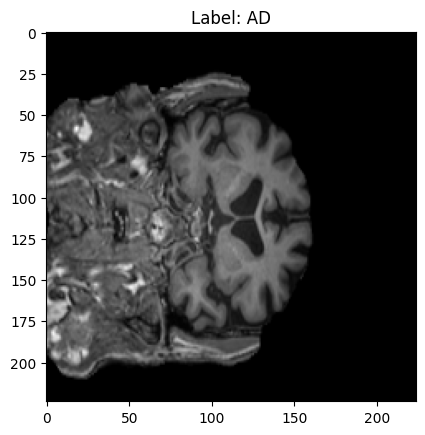

In [4]:
index_to_visualize = 3
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')

In [5]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu MobileNetV2 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [8]:
%%time
inputs = Input(shape=(224, 224, 3))

# Use MobileNetV2 as a layer in your model
def create_model():
    inputs = Input(shape=(224, 224, 3))
    base_model = MobileNetV2(
        weights='imagenet',
        input_tensor=inputs,
        include_top=False,
        input_shape=(224, 224, 3) 
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


CPU times: total: 93.8 ms
Wall time: 110 ms


In [9]:
# Use MobileNetV2 as a layer in your model
model = create_model()

# Display the model summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [10]:
# Fine-tuning
EPOCH = 25
BATCH_SIZE = 16
h_model = model.fit(X_train, Y_train, epochs=EPOCH, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE)

Epoch 1/25


360/360 [==============================] - 38s 100ms/step - loss: 1.3431 - accuracy: 0.3696 - val_loss: 1.2358 - val_accuracy: 0.4313
Epoch 2/25
360/360 [==============================] - 35s 97ms/step - loss: 1.1645 - accuracy: 0.4870 - val_loss: 1.2391 - val_accuracy: 0.4479
Epoch 3/25
360/360 [==============================] - 35s 96ms/step - loss: 1.0490 - accuracy: 0.5450 - val_loss: 1.0506 - val_accuracy: 0.5757
Epoch 4/25
360/360 [==============================] - 34s 94ms/step - loss: 0.9111 - accuracy: 0.6182 - val_loss: 0.9538 - val_accuracy: 0.6083
Epoch 5/25
360/360 [==============================] - 34s 95ms/step - loss: 0.7822 - accuracy: 0.6804 - val_loss: 0.8652 - val_accuracy: 0.6528
Epoch 6/25
360/360 [==============================] - 34s 94ms/step - loss: 0.6815 - accuracy: 0.7323 - val_loss: 0.9027 - val_accuracy: 0.6403
Epoch 7/25
360/360 [==============================] - 34s 94ms/step - loss: 0.5704 - accuracy: 0.7705 - val_loss: 0.7691 - val_accura

## 5. Testing

### 5.1 Menilai model pada data uji

In [11]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 7s 139ms/step - loss: 0.7190 - accuracy: 0.8090
Loss: 0.7190443873405457
Accuracy: 0.8090277910232544
45/45 [==============================] - 7s 134ms/step
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [0 1 2 ... 1 1 1]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

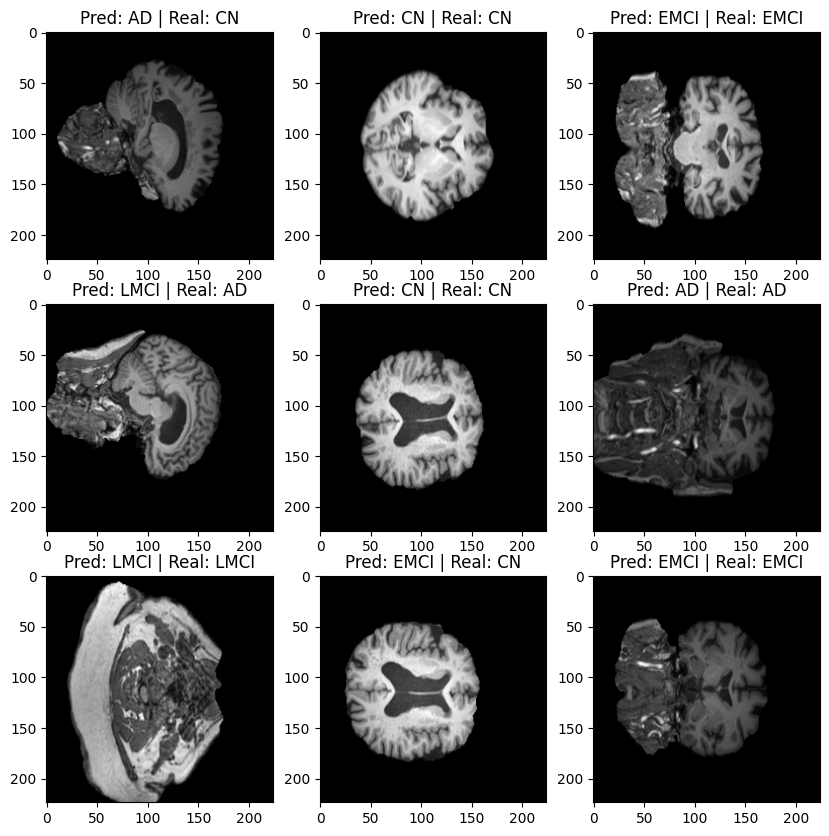

In [12]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i].astype("int64"))
    plt.imshow(X_test[i],cmap="gray")
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [13]:
import keras.backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi model pada data train

In [14]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 25s 135ms/step - loss: 0.0419 - accuracy: 0.9859 - specificity: 0.9957 - sensitivity: 0.9847
Loss train set:  0.041864119470119476
Akurasi train set:  0.9859374761581421
Specificity train set:  0.9957175254821777
Sensitivity train set:  0.9847221970558167


Evaluasi model pada data test

In [15]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test, Y_test)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

45/45 [==============================] - 6s 134ms/step - loss: 0.7190 - accuracy: 0.8090 - specificity: 0.9405 - sensitivity: 0.8014
Loss train set:  0.7190443873405457
Akurasi train set:  0.8090277910232544
Specificity train set:  0.9405092597007751
Sensitivity train set:  0.8013888597488403


Visualisasi confusion matrix

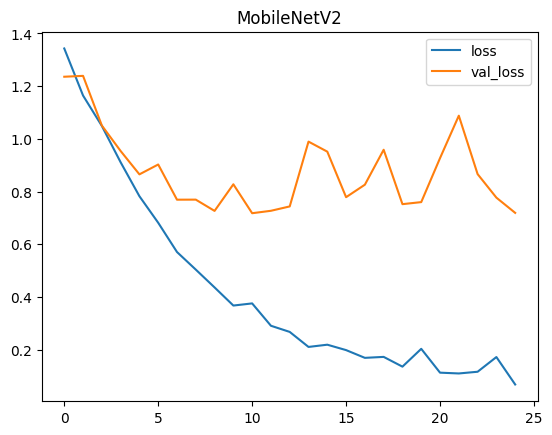

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('MobileNetV2')
plt.show()

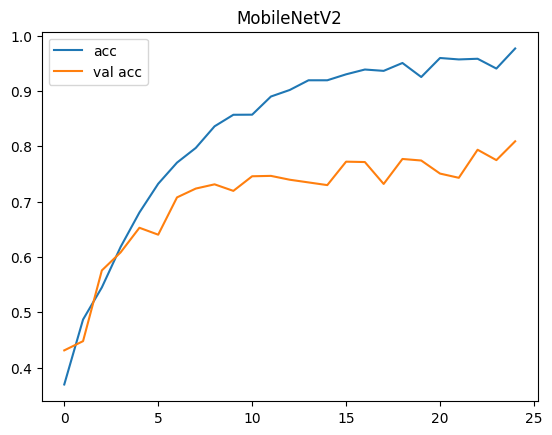

In [17]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('MobileNetV2')
plt.show()

In [18]:
current_directory = os.getcwd()
print("Direktori Kerja Saat Ini:", current_directory)

Direktori Kerja Saat Ini: d:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Skenario


In [19]:
# Simpan model
model.save(r"D:\Users\RESA\Coding\Evaluasi\MobileNetV2.h5")

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
y_preds =  model.predict(X_test)
y_preds

45/45 [==============================] - 7s 134ms/step


array([[9.9860114e-01, 1.3949008e-03, 3.0616081e-06, 8.2282781e-07],
       [3.2950209e-03, 9.9643087e-01, 2.6445134e-04, 9.6633903e-06],
       [1.6353292e-03, 7.6182606e-04, 9.9728251e-01, 3.2029237e-04],
       ...,
       [1.6960566e-01, 7.5239450e-01, 6.3572794e-02, 1.4427017e-02],
       [3.6134497e-05, 9.9992216e-01, 7.1474363e-07, 4.1019819e-05],
       [2.6435268e-05, 8.3331186e-01, 1.6649984e-01, 1.6182881e-04]],
      dtype=float32)

In [21]:
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([0, 1, 2, ..., 1, 1, 1], dtype=int64)

In [22]:
qwe=np.argmax(Y_test, axis=1)

In [23]:
confusion_matrix(qwe,y_preds_ind)

array([[330,  16,  21,  13],
       [ 26, 265,  32,  15],
       [ 14,  27, 290,  32],
       [ 29,  33,  17, 280]], dtype=int64)

In [24]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       380
           1       0.78      0.78      0.78       338
           2       0.81      0.80      0.80       363
           3       0.82      0.78      0.80       359

    accuracy                           0.81      1440
   macro avg       0.81      0.81      0.81      1440
weighted avg       0.81      0.81      0.81      1440



In [25]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 6s 134ms/step - loss: 0.7190 - accuracy: 0.8090 - specificity: 0.9405 - sensitivity: 0.8014


[0.7190443873405457,
 0.8090277910232544,
 0.9405092597007751,
 0.8013888597488403]

### 6.3 ROC AUC Curve

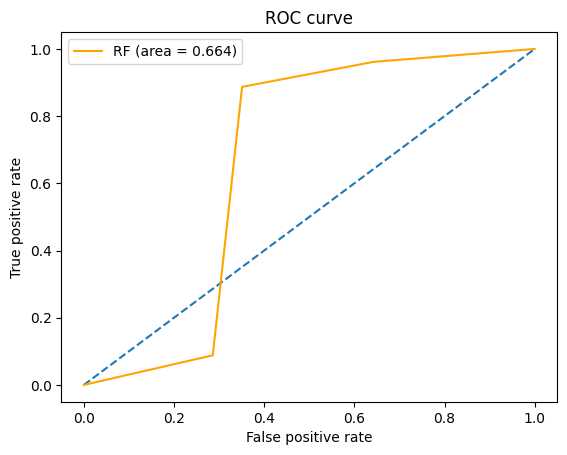

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Visualization

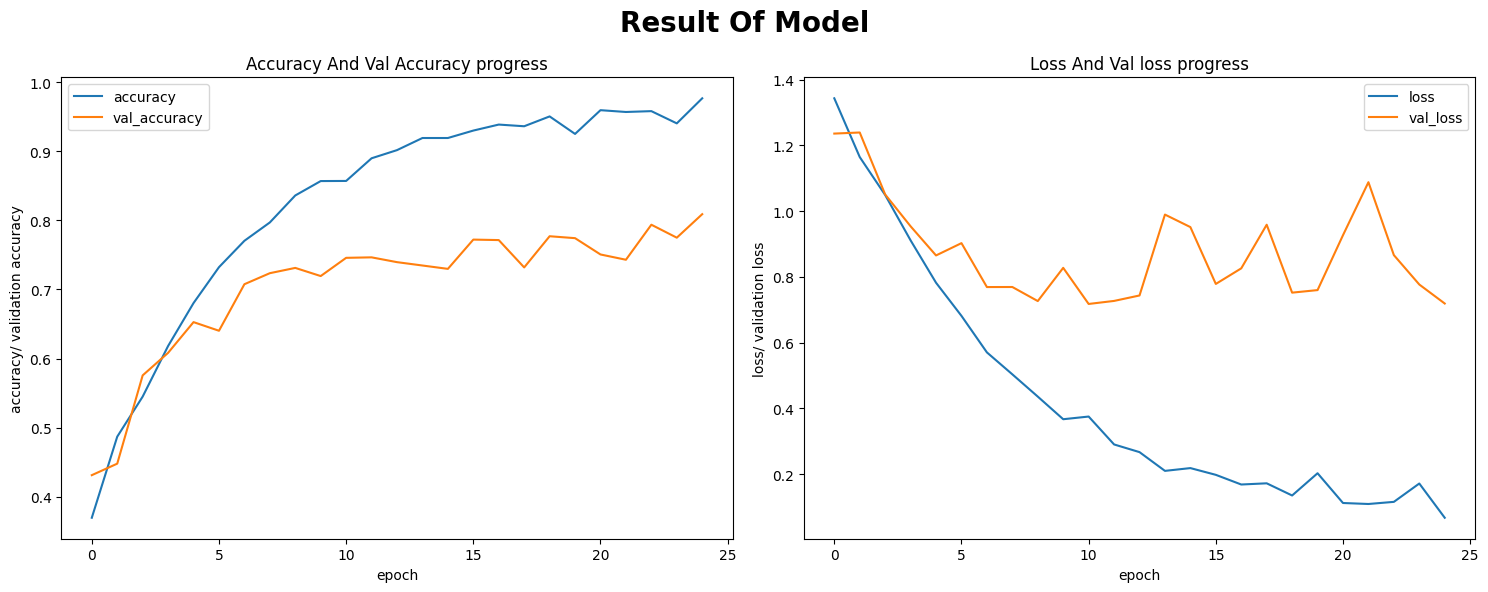

In [27]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross Validation

In [28]:
# Set early stopping criteria
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Tentukan model checkpoint callback
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5', verbose=1, save_best_only=True)

# Tentukan fungsi untuk fit model
def fit_and_evaluate(X_train, X_test, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=16):
    model = create_model()
    results = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test, Y_test))
    return results

### 7.1 Training

In [29]:
n_folds = 5
epochs = 20
batch_size = 16

# Save the model history after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                                random_state=np.random.randint(1, 1000, 1)[0])
    model_history.append(fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs, batch_size))
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
288/288 [==============================] - ETA: 0s - loss: 1.3670 - accuracy: 0.3520
Epoch 1: val_loss improved from inf to 1.25182, saving model to D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


288/288 [==============================] - 33s 101ms/step - loss: 1.3670 - accuracy: 0.3520 - val_loss: 1.2518 - val_accuracy: 0.4097
Epoch 2/20
288/288 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.4629
Epoch 2: val_loss improved from 1.25182 to 1.14466, saving model to D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5
288/288 [==============================] - 29s 102ms/step - loss: 1.1854 - accuracy: 0.4629 - val_loss: 1.1447 - val_accuracy: 0.4913
Epoch 3/20
288/288 [==============================] - ETA: 0s - loss: 1.0450 - accuracy: 0.5519
Epoch 3: val_loss improved from 1.14466 to 1.08435, saving model to D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5
288/288 [==============================] - 29s 102ms/step - loss: 1.0450 - accuracy: 0.5519 - val_loss: 1.0843 - val_accuracy: 0.5321
Epoch 4/20
288/288 [==============================] - ETA: 0s - loss: 0.9196 - accuracy: 0.6039
Epoch 4: val_loss improved from 1.08435 to 0.98401, saving model to D:\Users\RES

### 7.2 Evaluasi Cross - Validation

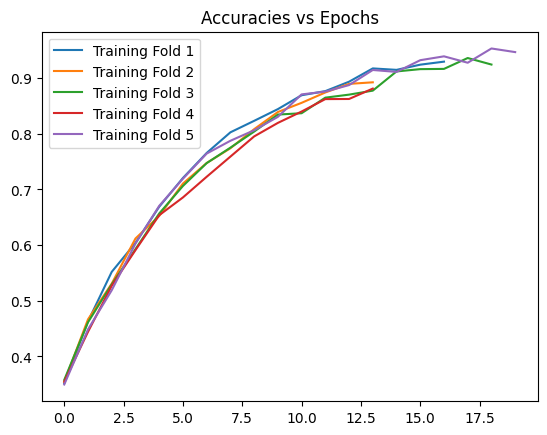

In [30]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()

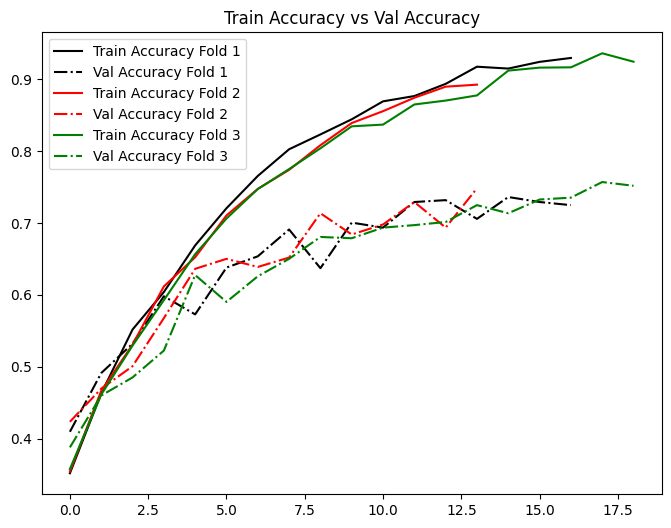

In [31]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [32]:
y_preds =  model.predict(X_test)
y_preds

45/45 [==============================] - 7s 148ms/step


array([[1.7305538e-02, 3.0401345e-06, 9.8264736e-01, 4.4040098e-05],
       [5.4349871e-09, 9.9816304e-01, 4.2082644e-05, 1.7948360e-03],
       [1.0000000e+00, 6.0637548e-09, 2.8978135e-09, 4.8808214e-12],
       ...,
       [3.3707622e-02, 7.6723546e-02, 2.1345330e-04, 8.8935536e-01],
       [1.0000000e+00, 1.3549385e-09, 3.0511853e-11, 1.6504707e-11],
       [9.8757809e-01, 3.3809161e-07, 1.2418312e-02, 3.1518007e-06]],
      dtype=float32)

In [33]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

array([2, 1, 0, ..., 3, 0, 0], dtype=int64)

In [34]:
asd = np.argmax(Y_test, axis=1)
asd

array([2, 1, 0, ..., 3, 0, 0], dtype=int64)

In [35]:
confusion_matrix(asd,y_preds_arg)

array([[329,   4,   4,   8],
       [  8, 343,  11,   2],
       [  3,   6, 347,   6],
       [  5,  12,  10, 342]], dtype=int64)

In [36]:
print(classification_report(asd,y_preds_arg))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       345
           1       0.94      0.94      0.94       364
           2       0.93      0.96      0.95       362
           3       0.96      0.93      0.94       369

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



In [37]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,fmt='g', cmap="viridis")
    plt.show()

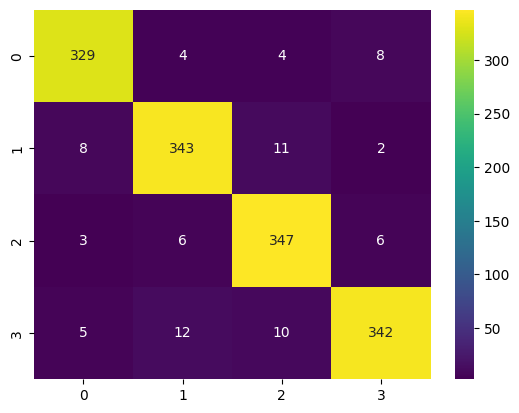

In [38]:
draw_confusion_matrix(asd,y_preds_arg)